In [1]:
!pip -q install seqeval
!pip -q install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

In [3]:
import numpy as np
import pandas as pd
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForTokenClassification, BertTokenizer, BertConfig, BertModel
from torch.nn import CrossEntropyLoss
import re

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
print(dev)
dev = torch.device(dev) 

cuda:0


In [4]:
## Possible Tags
tag_to_idx = {'O': 0, 'T-NEG': 1, 'T-POS': 2, 'T-NEU': 3, 'PAD':4}

## Data files
train_path = '/content/drive/MyDrive/sem5/NLP/data/laptop14/train.txt'
test_path = '/content/drive/MyDrive/sem5/NLP/data/laptop14/test.txt'
dev_path = '/content/drive/MyDrive/sem5/NLP/data/laptop14/dev.txt'

idx = 0

def get_data(path):
  f = open(path, 'r')
  data = []
  labels = []
  m1 = -1
  for line in f:
    line = line.split('####')
    data.append(line[0])
    tags = []
    line[1] = line[1].split()
    m1 = max(m1,len(line[1]))
    for word in line[1]:
      word = [word[:word.find('=')+1], word[len(word) - word[::-1].find('='):]]
      try:
        tags.append(tag_to_idx[word[1]])
      except:
        print(line)
    labels.append(tags)
  return data, labels, m1

train_data, train_labels, m1 = get_data(train_path)
test_data, test_labels, m2 = get_data(test_path)
dev_data, dev_labels, m3 = get_data(dev_path)

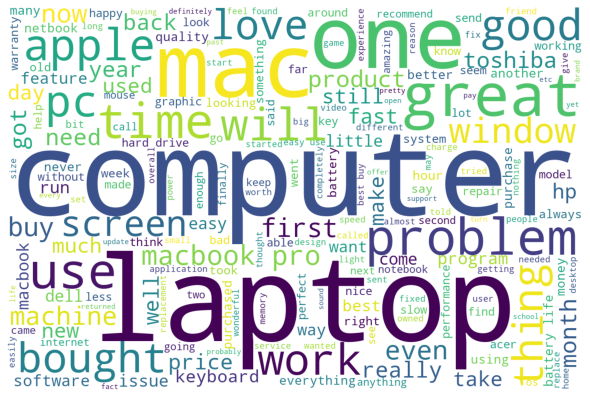

In [5]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
    
comment_words = '' 
stopwords = set(STOPWORDS) 

total_sentences = train_data + test_data + dev_data
for sent in total_sentences: 
    sent = sent.lower()
    tokens = sent.split() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1200, height = 800, background_color ='white', stopwords = stopwords, min_font_size = 1).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [6]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
lr = 1e-5
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [7]:
class dataset(Dataset):
    def __init__(self, tokenizer, sentences, labels, max_len):
        self.len = len(sentences)
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        label = self.labels[index]
        label.extend([4]*200)
        label=label[:MAX_LEN]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'tags': torch.tensor(label, dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [8]:
train_sentences = train_data
test_sentences = test_data
training_set = dataset(tokenizer, train_sentences, train_labels, MAX_LEN)
testing_set = dataset(tokenizer, test_sentences, test_labels, MAX_LEN)
dev_set = dataset(tokenizer, dev_data, dev_labels, MAX_LEN)

In [9]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

dev_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }


training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
dev_loader = DataLoader(dev_set, **dev_params)

In [15]:
class BERT(torch.nn.Module):
    def __init__(self, num_labels):
        super(BERT, self).__init__()
        self.num_labels = num_labels
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased', add_pooling_layer=False)
        self.dropout = torch.nn.Dropout(0.1)
        self.conv1 = torch.nn.Conv1d(100, 100, 5)
        self.conv2 = torch.nn.Conv1d(100, 100, 3)
        self.conv3 = torch.nn.Conv1d(100, 100, 1)
        self.fc1 = torch.nn.Linear(762, 128)
        self.act = torch.nn.ReLU()
        self.classifier = torch.nn.Linear(128, self.num_labels)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output)
        sequence_output = self.conv1(sequence_output)
        sequence_output = self.conv2(sequence_output)
        sequence_output = self.conv3(sequence_output)

        sequence_output = self.fc1(sequence_output)
        sequence_output = self.act(sequence_output)

        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            weights = [0.1, 1.0, 1.0, 1.0, 0.0]
            class_weights = torch.FloatTensor(weights).cuda()
            loss_fct = CrossEntropyLoss(weight=class_weights)
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        output = (logits,) + outputs[2:]
        return ((loss,) + output) if loss is not None else output

In [16]:
model = BERT(5)
model.to(dev)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       

In [17]:
optimizer = transformers.AdamW(params =  model.parameters(), lr=lr)

In [18]:
lo = {}
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(dev, dtype = torch.long)
        mask = data['mask'].to(dev, dtype = torch.long)
        targets = data['tags'].to(dev, dtype = torch.long)
        loss = model(ids, mask, labels = targets)[0]
        if _%500==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
        lo[epoch] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [46]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  0.6411337852478027
Epoch: 1, Loss:  0.6058903932571411
Epoch: 2, Loss:  0.6497702598571777
Epoch: 3, Loss:  0.6578772664070129
Epoch: 4, Loss:  0.6716325283050537
Epoch: 5, Loss:  0.5738837122917175
Epoch: 6, Loss:  0.5871322154998779
Epoch: 7, Loss:  0.5929161310195923
Epoch: 8, Loss:  0.5138969421386719
Epoch: 9, Loss:  0.5410968661308289


In [ ]:
ep = [i for i in range(EPOCHS)]
loss = []
for i in range(EPOCHS):
  loss.append(lo[i])

plt.plot(ep, loss)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training History')
plt.show()

In [21]:
tag_vals = ['O', 'T-NEG', 'T-POS', 'T-NEU', 'PAD']

def valid(model, testing_loader):
    model.eval()
    eval_loss = 0; eval_accuracy = 0
    n_correct = 0; n_wrong = 0; total = 0
    predictions , true_labels = [], []
    nb_eval_steps, nb_eval_examples = 0, 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(dev, dtype = torch.long)
            mask = data['mask'].to(dev, dtype = torch.long)
            targets = data['tags'].to(dev, dtype = torch.long)

            output = model(ids, mask, labels=targets)
            loss, logits = output[:2]
            logits = logits.detach().cpu().numpy()
            label_ids = targets.to('cpu').numpy()
            predictions.append([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.append(label_ids)
            eval_loss += loss.mean().item()
            nb_eval_examples += ids.size(0)
            nb_eval_steps += 1
        eval_loss = eval_loss/nb_eval_steps
        return predictions, true_labels

In [48]:
# To get the results on the test set. This data is not seen by the model
p,t = valid(model, testing_loader)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [49]:
y_true = []
y_pred = []
for batch in range(len(t)):
  for entry in range(len(t[batch])):
    N = 0
    while t[batch][entry][N] != 4 and N<len(p[batch][entry]) and N<len(t[batch][entry]):
      N+=1 
    try:
      a = [tag_vals[p[batch][entry][i]] for i in range(N)]
      y_pred.append(a)
      b = [tag_vals[t[batch][entry][i]] for i in range(N)]
      y_true.append(b)
    except:
      print("Error")

In [50]:
for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    if y_pred[i][j] == 'PAD':
      y_pred[i][j] = 'O'


from sklearn import metrics
yp = [tag for sent in y_pred for tag in sent]
yt = [tag for sent in y_true for tag in sent]

print(metrics.classification_report(yt, yp))

              precision    recall  f1-score   support

           O       0.95      0.84      0.89     10631
       T-NEG       0.07      0.21      0.11       210
       T-NEU       0.14      0.28      0.18       330
       T-POS       0.18      0.34      0.23       499

    accuracy                           0.79     11670
   macro avg       0.33      0.42      0.35     11670
weighted avg       0.87      0.79      0.83     11670



In [51]:
print(metrics.confusion_matrix(yt, yp))

[[8885  503  480  763]
 [ 117   44   36   13]
 [ 175   32   93   30]
 [ 224   32   72  171]]


In [52]:
PATH = '/content/drive/MyDrive/sem5/NLP/absa_laptop_cnn.sav'
## Save
torch.save(model.state_dict(), PATH)
## Load

# model = BERT()
# model.load_state_dict(torch.load(PATH))
# model.eval()

TEST WITH YOUR SENTENCES

In [102]:
sent = {'NEG':'Negative', 'POS': 'Positive', 'NEU':'Neutral'}

sentence = 'Apple is always great about the aesthetics of things, they always come up with good looking products.'
sentence = sentence.lower()
inputs = tokenizer(sentence, return_tensors="pt", max_length= 100 ,padding='max_length')
id = inputs['input_ids'].to(dev)
att = inputs['attention_mask'].to(dev)
output = model(id, att)
logits = output[0]
logits = logits.detach().cpu().numpy()
a = [list(p) for p in np.argmax(logits, axis=2)]
out = a[0]
out = [tag_vals[i] for i in out]

asp = []
inpu = sentence.split()
out = out[:len(inpu)]

i = 0
while i< len(out):
  if out[i] != 'O' and out[i] !='PAD':
    j = i
    aspect_term = []
    while j<len(out) and out[j] == out[i]:
      aspect_term.append(inpu[j]) 
      j+=1
    aspect_term = ' '.join(aspect_term)
    asp.append((aspect_term,out[i][2:]))
    i = j
  else:
    i+=1

In [103]:
for entry in asp:
  print('Aspect Term: {}, Sentiment: {}'.format(entry[0], sent[entry[1]]))

Aspect Term: about, Sentiment: Positive
Aspect Term: aesthetics of things,, Sentiment: Positive
